In [1]:
import uproot
import awkward as ak
import numpy as np

# Open File

In [2]:
file = uproot.open("/lstr/sahara/act/data/DAOD_PHYSLITE.37621365._000015.pool.root.1")

## CPU 
Benchmarking with NumPy based calculation 

### Checking Variables to be used:

What objects are in this file? What's the name of the ttree?

In [3]:
file.keys()

['##Params;3',
 '##Params;2',
 '##Shapes;3',
 '##Shapes;2',
 '##Links;3',
 '##Links;2',
 'MetaData;1',
 'MetaDataHdr;1',
 'MetaDataHdrForm;1',
 'CollectionTree;1',
 'POOLContainer;1',
 'POOLContainerForm;1',
 'POOLCollectionTree;1']

In [4]:
# Access ttree
tree = file["CollectionTree;1"] # fix me

In [6]:
# we can see the list of branch names using tree.keys()
tree.keys()

['xTrigDecisionAux.',
 'xTrigDecisionAux./xTrigDecisionAux.xAOD::AuxInfoBase',
 'xTrigDecisionAux./xTrigDecisionAux.smk',
 'xTrigDecisionAux./xTrigDecisionAux.bgCode',
 'xTrigDecisionAux./xTrigDecisionAux.tav',
 'xTrigDecisionAux./xTrigDecisionAux.tap',
 'xTrigDecisionAux./xTrigDecisionAux.tbp',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2ErrorBits',
 'xTrigDecisionAux./xTrigDecisionAux.efErrorBits',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2Truncated',
 'xTrigDecisionAux./xTrigDecisionAux.efTruncated',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2PassedPhysics',
 'xTrigDecisionAux./xTrigDecisionAux.efPassedPhysics',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2PassedRaw',
 'xTrigDecisionAux./xTrigDecisionAux.efPassedRaw',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2PassedThrough',
 'xTrigDecisionAux./xTrigDecisionAux.efPassedThrough',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2Prescaled',
 'xTrigDecisionAux./xTrigDecisionAux.efPrescaled',
 'xTrigDecisionAux./xTrigDecisionAux.lvl2Resurrected',
 'xTrigD

In [ ]:
# or you can use tree.show() to see more information on the branches
tree.show()

# Setting Things for Jets 


In [5]:
x = len(tree) # fix me
print("Number of branches:", x)

Number of branches: 1360


In [6]:
Jets = tree.arrays([
    "AnalysisJetsAuxDyn.pt", 
    "AnalysisJetsAuxDyn.eta", 
    "AnalysisJetsAuxDyn.phi", 
    "AnalysisJetsAuxDyn.m"
])


How many events are in this tree?

In [7]:
num_events = len(Jets) # fix me
print("Number of events:", num_events)

Number of events: 200000


# CPU 

In [10]:
import numpy as np
import awkward as ak
import time

start = time.time()

# Load 4-vector components
pt  = Jets["AnalysisJetsAuxDyn.pt"]
eta = Jets["AnalysisJetsAuxDyn.eta"]
phi = Jets["AnalysisJetsAuxDyn.phi"]
mass = Jets["AnalysisJetsAuxDyn.m"]

# Convert to px, py, pz, E
px = pt * np.cos(phi)
py = pt * np.sin(phi)
pz = pt * np.sinh(eta)
E  = np.sqrt(mass**2 + px**2 + py**2 + pz**2)

# Invariant mass per jet
mass2 = E**2 - (px**2 + py**2 + pz**2)
valid_mask = mass2 > 0
invariant_mass = np.sqrt(mass2[valid_mask])

flat_mass = ak.to_numpy(ak.flatten(invariant_mass))
print(f"Mean jet mass: {np.mean(flat_mass):.3f} GeV, Total jets: {len(flat_mass)}")

end = time.time()
print(f"Elapsed time: {end - start:.4f} seconds")


Mean jet mass: 6736.500 GeV, Total jets: 1220552
Elapsed time: 0.0656 seconds


# GPU



In [11]:
import cupy as cp
import awkward as ak
import time

start = time.time()

# Load and flatten components, convert to CuPy arrays
pt  = cp.asarray(ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.pt"])))
eta = cp.asarray(ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.eta"])))
phi = cp.asarray(ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.phi"])))
mass = cp.asarray(ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.m"])))

# Convert to px, py, pz, E
px = pt * cp.cos(phi)
py = pt * cp.sin(phi)
pz = pt * cp.sinh(eta)
E  = cp.sqrt(mass**2 + px**2 + py**2 + pz**2)

# Invariant mass per jet
mass2 = E**2 - (px**2 + py**2 + pz**2)

# Only use valid masses (mass2 >= 0)
invariant_mass = cp.sqrt(cp.clip(mass2, 0, None))

# Move to CPU for final output
invariant_mass_cpu = cp.asnumpy(invariant_mass)
mean_mass = invariant_mass_cpu.mean()
total_jets = len(invariant_mass_cpu)

print(f"Mean jet mass: {mean_mass:.3f} GeV, Total jets: {total_jets}")

end = time.time()
print(f"Elapsed GPU time: {end - start:.4f} seconds")


Mean jet mass: 6538.122 GeV, Total jets: 1257587
Elapsed GPU time: 0.3201 seconds


## Further Look at CPU vs GPU 

First GPU 

In [12]:
import numpy as np
import cupy as cp
import awkward as ak
import time

# Load NumPy arrays from Awkward (on CPU)
pt_cpu  = ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.pt"]))
eta_cpu = ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.eta"]))
phi_cpu = ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.phi"]))
mass_cpu = ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.m"]))

# Transfer to GPU all at once
pt  = cp.asarray(pt_cpu)
eta = cp.asarray(eta_cpu)
phi = cp.asarray(phi_cpu)
mass = cp.asarray(mass_cpu)

# Start GPU timing
cp.cuda.Device(0).synchronize()
start = time.time()

# Compute everything on GPU
px = pt * cp.cos(phi)
py = pt * cp.sin(phi)
pz = pt * cp.sinh(eta)
E  = cp.sqrt(cp.maximum(mass**2 + px**2 + py**2 + pz**2, 0))

mass2 = E**2 - (px**2 + py**2 + pz**2)
invariant_mass = cp.where(mass2 > 0, cp.sqrt(mass2), -1.0)

cp.cuda.Device(0).synchronize()
end = time.time()

# Transfer result back to CPU only once
flat_mass = cp.asnumpy(invariant_mass)

print(f"[GPU] Mean jet mass: {np.mean(flat_mass):.3f} GeV, Total jets: {len(flat_mass)}")
print(f"[GPU] Time elapsed: {end - start:.4f} s")


[GPU] Mean jet mass: 6538.093 GeV, Total jets: 1257587
[GPU] Time elapsed: 0.0068 s


In [13]:
# CPU version
start = time.time()

px = pt_cpu * np.cos(phi_cpu)
py = pt_cpu * np.sin(phi_cpu)
pz = pt_cpu * np.sinh(eta_cpu)
E  = np.sqrt(np.maximum(mass_cpu**2 + px**2 + py**2 + pz**2, 0))

mass2 = E**2 - (px**2 + py**2 + pz**2)
invariant_mass = np.where(mass2 > 0, np.sqrt(mass2), -1.0)

end = time.time()
print(f"[CPU] Mean jet mass: {np.mean(invariant_mass):.3f} GeV, Total jets: {len(invariant_mass)}")
print(f"[CPU] Time elapsed: {end - start:.4f} s")


[CPU] Mean jet mass: 6538.083 GeV, Total jets: 1257587
[CPU] Time elapsed: 0.0347 s


/tmp/ipykernel_1352278/4016266324.py:10: RuntimeWarning: invalid value encountered in sqrt
  invariant_mass = np.where(mass2 > 0, np.sqrt(mass2), -1.0)


## GPU requires some setup compared to CPU 

Generally, the first few times running GPU takes a second to warm up, but the final result is timing much faster than that of CPU for parallelizable calculations. Since most of the code is reused from previous cells, I have put all of this logic into one cell where we combine the pieces into a more cohesive whole. 

/tmp/ipykernel_1353421/823942669.py:29: RuntimeWarning: invalid value encountered in sqrt
  _    = np.where(mass2 > 0, np.sqrt(mass2), -1.0)   # result unused – timing only


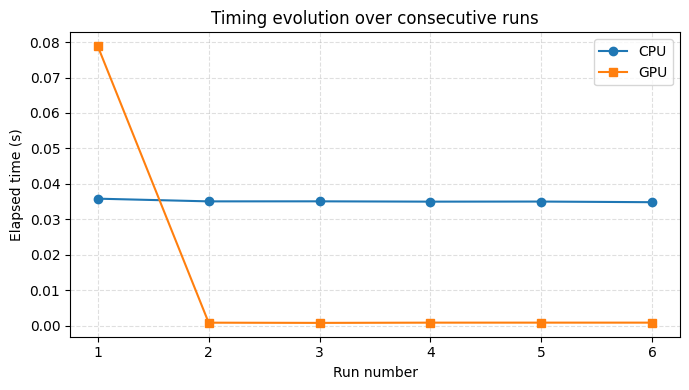

In [8]:
import numpy as np, cupy as cp, awkward as ak, time, matplotlib.pyplot as plt

# ------------------------
# 1.  Pull data to CPU once
# ------------------------
pt_cpu  = ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.pt"]))
eta_cpu = ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.eta"]))
phi_cpu = ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.phi"]))
mass_cpu= ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.m"]))

# ------------------------
# 2.  Copy to GPU once
# ------------------------
pt   = cp.asarray(pt_cpu)
eta  = cp.asarray(eta_cpu)
phi  = cp.asarray(phi_cpu)
mass = cp.asarray(mass_cpu)

# ---------------------------------------
# 3.  Helper that times ONE full pass
# ---------------------------------------
def jet_mass_cpu():
    start = time.perf_counter()
    px = pt_cpu * np.cos(phi_cpu)
    py = pt_cpu * np.sin(phi_cpu)
    pz = pt_cpu * np.sinh(eta_cpu)
    E  = np.sqrt(np.maximum(mass_cpu**2 + px**2 + py**2 + pz**2, 0))
    mass2 = E**2 - (px**2 + py**2 + pz**2)
    _    = np.where(mass2 > 0, np.sqrt(mass2), -1.0)   # result unused – timing only
    return time.perf_counter() - start

def jet_mass_gpu():
    cp.cuda.Device(0).synchronize()
    start = time.perf_counter()
    px = pt * cp.cos(phi)
    py = pt * cp.sin(phi)
    pz = pt * cp.sinh(eta)
    E  = cp.sqrt(cp.maximum(mass**2 + px**2 + py**2 + pz**2, 0))
    mass2 = E**2 - (px**2 + py**2 + pz**2)
    _ = cp.where(mass2 > 0, cp.sqrt(mass2), -1.0)
    cp.cuda.Device(0).synchronize()
    return time.perf_counter() - start

# -------------------------------------------------
# 4.  Run six times each and store elapsed seconds
# -------------------------------------------------
cpu_times = [jet_mass_cpu() for _ in range(6)]
gpu_times = [jet_mass_gpu() for _ in range(6)]

# --------------------------------------------
# 5.  Visualise:  CPU stays flat, GPU drops
# --------------------------------------------
runs = np.arange(1, 7)
plt.figure(figsize=(7,4))
plt.plot(runs, cpu_times, marker='o', label='CPU')
plt.plot(runs, gpu_times, marker='s', label='GPU')
plt.xlabel('Run number')
plt.ylabel('Elapsed time (s)')
plt.title('Timing evolution over consecutive runs')
plt.xticks(runs)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


# Now if we want to try some Cuda timing!! 

In [ ]:
# First making sure to declare properly the 4-vector elements 

import numpy as np, awkward as ak, struct

pt   = ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.pt"])).astype(np.float32)
eta  = ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.eta"])).astype(np.float32)
phi  = ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.phi"])).astype(np.float32)
mass = ak.to_numpy(ak.flatten(Jets["AnalysisJetsAuxDyn.m" ]).astype(np.float32)

with open("jets.bin","wb") as f:
    f.write(struct.pack("Q", pt.size))         # 8‑byte N
    for arr in (pt, eta, phi, mass): arr.tofile(f)
